In [2]:
!pip install kaggle

!kaggle datasets download -d danialsharifrazi/cad-cardiac-mri-dataset

import zipfile
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

Dataset URL: https://www.kaggle.com/datasets/danialsharifrazi/cad-cardiac-mri-dataset
License(s): unknown
100%|██████████████████████████████████████▉| 2.86G/2.86G [00:10<00:00, 307MB/s]
100%|███████████████████████████████████████| 2.86G/2.86G [00:10<00:00, 292MB/s]


In [3]:
with zipfile.ZipFile('cad-cardiac-mri-dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working')

# Define the main directory path
main_dir = '/kaggle/working/cad-cardiac-mri-dataset'

In [4]:
main_dir = '/kaggle/working'

In [5]:
import os
import cv2
import numpy as np

# Define lists to store images and labels
normal_images = []
sick_images = []

normal_count = 0
sick_count = 0

for category in os.listdir(main_dir):
    category_path = os.path.join(main_dir, category)
    if os.path.isdir(category_path):
        # Condition to separate normal and sick directories
        if 'normal' in category.lower() and normal_count < 10:
            for subdir, _, files in os.walk(category_path):
                for file in files:
                    file_path = os.path.join(subdir, file)
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (128, 128))  #Resize
                    normal_images.append(img)
            normal_count += 1
        elif 'sick' in category.lower() and sick_count < 10:
            for subdir, _, files in os.walk(category_path):
                for file in files:
                    file_path = os.path.join(subdir, file)
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, (128, 128))  # Example resize
                    sick_images.append(img)
            sick_count += 1
            
normal_images = np.array(normal_images)
sick_images = np.array(sick_images)
print("Loaded normal images:", normal_images.shape)
print("Loaded sick images:", sick_images.shape)

Loaded normal images: (37564, 128, 128)
Loaded sick images: (25861, 128, 128)


Image dtype: uint8


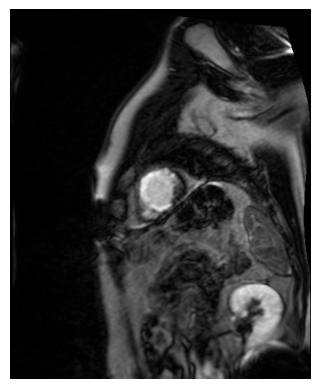

In [6]:
import cv2
import matplotlib.pyplot as plt

def display_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(f"Image dtype: {image.dtype}")
    plt.imshow(image)
    plt.axis('off')
    plt.show()

example_image_path = '/kaggle/working/Sick/Directory_23/SR_84/IM00001.jpg'
display_image(example_image_path)

In [7]:
def load_image_sequences(main_dir, label, num_sequences=10, time_steps=10, img_size=(128, 128)):
    sequences = []
    labels = []
    count = 0
    for category in os.listdir(main_dir):
        if count >= num_sequences:
            break
        category_path = os.path.join(main_dir, category)
        if os.path.isdir(category_path) and label.lower() in category.lower():
            sequence = []
            for subdir, _, files in os.walk(category_path):
                files = sorted(files)[:time_steps]
                for file in files:
                    file_path = os.path.join(subdir, file)
                    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, img_size) / 255.0
                    sequence.append(img)
            if len(sequence) == time_steps:
                sequences.append(np.array(sequence))
                labels.append(1 if label == "sick" else 0)
            count += 1
            
    return np.array(sequences), np.array(labels)

normal_sequences, normal_labels = load_image_sequences(main_dir, label="normal")
sick_sequences, sick_labels = load_image_sequences(main_dir, label="sick")
X = np.concatenate((normal_sequences, sick_sequences), axis=0)
y = np.concatenate((normal_labels, sick_labels), axis=0)

In [8]:
TIME_STEPS = 10
X = X.reshape(-1, TIME_STEPS, 128, 128, 1)

In [9]:
def load_image_sequences(main_dir, label, num_sequences=10):
    sequences = []
    labels = []
    category_path = os.path.join(main_dir, label)

    if not os.path.exists(category_path):
        print(f"Directory does not exist: {category_path}")
        return np.array(sequences), np.array(labels)
    image_files = os.listdir(category_path)
    print(f"Found {len(image_files)} images in {label} category.")
    count = 0

    for file in image_files:
        file_path = os.path.join(category_path, file)
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))
                sequences.append(img)
                count += 1
            if count >= num_sequences:
                break
                
    print(f"Loaded {count} images for label: {label}")
    return np.array(sequences), np.array([0] * count)  # Adjust labels accordingly

In [10]:
import matplotlib.pyplot as plt

def display_images(images, title):
    plt.figure(figsize=(12, 6))
    for i in range(min(len(images), 5)):  # Show up to 5 images
        plt.subplot(1, 5, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

display_images(normal_sequences, 'Normal Images')
display_images(sick_sequences, 'Sick Images')

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

In [11]:
def load_image_sequences(main_dir, label, num_sequences=10):
    sequences = []
    labels = []
    category_path = os.path.join(main_dir, label)

    if not os.path.exists(category_path):
        print(f"Directory does not exist: {category_path}")
        return np.array(sequences), np.array(labels)
    image_files = os.listdir(category_path)
    print(f"Found {len(image_files)} images in {label} category.")
    print("All files found in category:", image_files)
    count = 0

    for file in image_files:
        file_path = os.path.join(category_path, file)
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (128, 128))  # Resize to match the model input
                sequences.append(img)
                count += 1

            if count >= num_sequences:
                break

    print(f"Loaded {count} images for label: {label}")
    return np.array(sequences), np.array([0] * count)

normal_sequences, normal_labels = load_image_sequences(main_dir, 'Normal', num_sequences=10)
sick_sequences, sick_labels = load_image_sequences(main_dir, 'Sick', num_sequences=10)
print("Normal sequences shape:", normal_sequences.shape)
print("Sick sequences shape:", sick_sequences.shape)

Found 16 images in Normal category.
All files found in category: ['Directory_16', 'Directory_5', 'Directory_3', 'Directory_1', 'Directory_2', 'Directory_6', 'Directory_13', 'Directory_15', 'Directory_7', 'Directory_11', 'Directory_12', 'Directory_8', 'Directory_9', 'Directory_10', 'Directory_14', 'Directory_4']
Loaded 0 images for label: Normal
Found 14 images in Sick category.
All files found in category: ['Directory_23', 'Directory_28', 'Directory_18', 'Directory_24', 'Directory_17', 'Directory_30', 'Directory_25', 'Directory_27', 'Directory_26', 'Directory_29', 'Directory_19', 'Directory_22', 'Directory_20', 'Directory_21']
Loaded 0 images for label: Sick
Normal sequences shape: (0,)
Sick sequences shape: (0,)


In [12]:
import os
import cv2
import numpy as np

def load_image_sequences(main_dir, label, num_sequences=10):
    sequences = []
    labels = []
    category_path = os.path.join(main_dir, label)
    
    if not os.path.exists(category_path):
        print(f"Directory does not exist: {category_path}")
        return np.array(sequences), np.array(labels)
    count = 0

    for subdir, _, files in os.walk(category_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (128, 128))  # Resize to match the model input
                    sequences.append(img)
                    count += 1
                if count >= num_sequences:
                    break

        if count >= num_sequences:
            break
    print(f"Loaded {count} images for label: {label}")
    return np.array(sequences), np.array([0] * count)  # Adjust labels accordingly

normal_sequences, normal_labels = load_image_sequences(main_dir, 'Normal', num_sequences=10)
sick_sequences, sick_labels = load_image_sequences(main_dir, 'Sick', num_sequences=10)

print("Normal sequences shape:", normal_sequences.shape)
print("Sick sequences shape:", sick_sequences.shape)

Loaded 10 images for label: Normal
Loaded 10 images for label: Sick
Normal sequences shape: (10, 128, 128)
Sick sequences shape: (10, 128, 128)


In [13]:
from sklearn.model_selection import train_test_split

TIME_STEPS = 10
normal_sequences = normal_sequences.reshape(1, TIME_STEPS, 128, 128, 1)
sick_sequences = sick_sequences.reshape(1, TIME_STEPS, 128, 128, 1)      

X = np.concatenate((normal_sequences, sick_sequences), axis=0)
y = np.array([0, 1])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (1, 10, 128, 128, 1)
Validation data shape: (1, 10, 128, 128, 1)
Training labels shape: (1,)
Validation labels shape: (1,)


In [14]:
normal_sequences, normal_labels = load_image_sequences(main_dir, 'Normal', num_sequences=50)  # Increase the number as needed
sick_sequences, sick_labels = load_image_sequences(main_dir, 'Sick', num_sequences=50)

print("Normal sequences shape:", normal_sequences.shape)
print("Sick sequences shape:", sick_sequences.shape)

Loaded 50 images for label: Normal
Loaded 50 images for label: Sick
Normal sequences shape: (50, 128, 128)
Sick sequences shape: (50, 128, 128)


In [15]:
import numpy as np

from sklearn.model_selection import train_test_split

TIME_STEPS = 10


normal_sequences_reshaped = normal_sequences[:TIME_STEPS].reshape(1, TIME_STEPS, 128, 128, 1)
sick_sequences_reshaped = sick_sequences[:TIME_STEPS].reshape(1, TIME_STEPS, 128, 128, 1)

X = np.concatenate((normal_sequences_reshaped, sick_sequences_reshaped), axis=0)
y = np.array([0, 1])

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Training data shape: (1, 10, 128, 128, 1)
Validation data shape: (1, 10, 128, 128, 1)
Training labels shape: (1,)
Validation labels shape: (1,)


In [16]:
import os
import cv2
import numpy as np

def load_image_sequences(main_dir, label, max_images=50):
    sequences = []
    labels = []
    category_path = os.path.join(main_dir, label)

    if not os.path.exists(category_path):
        print(f"Directory does not exist: {category_path}")
        return np.array(sequences), np.array(labels)
    count = 0

    for subdir, _, files in os.walk(category_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (128, 128))
                    sequences.append(img)
                    count +=1

                if count >= max_images:
                    break

        if count >= max_images:
            break

    print(f"Loaded {count} images for label: {label}")
    return np.array(sequences), np.array([0] * count)

normal_sequences, normal_labels = load_image_sequences(main_dir, 'Normal', max_images=100)
sick_sequences, sick_labels = load_image_sequences(main_dir, 'Sick', max_images=100)


print("Normal sequences shape:", normal_sequences.shape)
print("Sick sequences shape:", sick_sequences.shape)


X = np.concatenate((normal_sequences, sick_sequences), axis=0)
y = np.concatenate((normal_labels, sick_labels), axis=0)


print("Combined sequences shape:", X.shape)
print("Combined labels shape:", y.shape)

Loaded 100 images for label: Normal
Loaded 100 images for label: Sick
Normal sequences shape: (100, 128, 128)
Sick sequences shape: (100, 128, 128)
Combined sequences shape: (200, 128, 128)
Combined labels shape: (200,)


In [17]:
import os
import cv2
import numpy as np


def load_image_sequences(main_dir, label, num_sequences=100):  
    sequences = []
    labels = []
    category_path = os.path.join(main_dir, label)


    if not os.path.exists(category_path):
        print(f"Directory does not exist: {category_path}")
        return np.array(sequences), np.array(labels)

    count = 0

    for subdir, _, files in os.walk(category_path):
        for file in files:
            file_path = os.path.join(subdir, file)
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    img = cv2.resize(img, (128, 128)) 
                    sequences.append(img)
                    count += 1

                if count >= num_sequences:
                    break

        if count >= num_sequences:
            break

    print(f"Loaded {count} images for label: {label}")
    return np.array(sequences), np.array([0] * count)  # Adjust labels accordingly

In [18]:
normal_sequences, normal_labels = load_image_sequences(main_dir, 'Normal', num_sequences=100)
sick_sequences, sick_labels = load_image_sequences(main_dir, 'Sick', num_sequences=100)

print("Normal sequences shape:", normal_sequences.shape)
print("Sick sequences shape:", sick_sequences.shape)

X = np.concatenate((normal_sequences, sick_sequences), axis=0)
y = np.concatenate((np.zeros(normal_sequences.shape[0]), np.ones(sick_sequences.shape[0])))

TIME_STEPS = 1  

X_reshaped = X.reshape(-1, TIME_STEPS, 128, 128, 1)


print("Combined sequences shape after reshaping:", X_reshaped.shape)
print("Labels shape:", y.shape)

X_train, X_val, y_train, y_val = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)
print("Training labels shape:", y_train.shape)
print("Validation labels shape:", y_val.shape)

Loaded 100 images for label: Normal
Loaded 100 images for label: Sick
Normal sequences shape: (100, 128, 128)
Sick sequences shape: (100, 128, 128)
Combined sequences shape after reshaping: (200, 1, 128, 128, 1)
Labels shape: (200,)
Training data shape: (160, 1, 128, 128, 1)
Validation data shape: (40, 1, 128, 128, 1)
Training labels shape: (160,)
Validation labels shape: (40,)


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

model = models.Sequential()

model.add(layers.TimeDistributed(layers.Conv2D(16, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)), input_shape=(10, 128, 128, 1)))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))))
model.add(layers.TimeDistributed(layers.MaxPooling2D((2, 2))))
model.add(layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))))
model.add(layers.TimeDistributed(layers.Flatten()))

model.add(layers.LSTM(32, activation='relu'))
model.add(layers.Dropout(0.4))

model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

datagen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

def augment_sequences(X):
    X_aug = np.zeros_like(X)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X_aug[i, j] = datagen.random_transform(X[i, j])
    return X_aug


X_train_aug = augment_sequences(X_train)

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 10, 126, 126,   │           160 │
│ (TimeDistributed)               │ 16)                    │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 10, 63, 63, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 10, 61, 61, 32) │         4,640 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 10, 30, 30, 32) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 10, 28, 28, 32) │         9,248 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 10, 25088)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 32)             │     3,215,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,229,569 (12.32 MB)

 Trainable params: 3,229,569 (12.32 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Train the model
history = model.fit(X_train_aug, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,  # More epochs with early stopping
                    batch_size=16)

Epoch 1/30


I0000 00:00:1740905981.644625     112 service.cc:145] XLA service 0x78d27c006b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740905981.644695     112 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/10 ━━━━━━━━━━━━━━━━━━━━ 55s 6s/step - accuracy: 0.4375 - loss: 2.1837

I0000 00:00:1740905985.539139     112 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 142ms/step - accuracy: 0.4963 - loss: 2.9278 - val_accuracy: 0.6250 - val_loss: 1.2396
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5903 - loss: 1.3321 - val_accuracy: 0.6250 - val_loss: 1.5063
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5964 - loss: 1.2370 - val_accuracy: 0.4750 - val_loss: 1.1253
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6315 - loss: 1.1940 - val_accuracy: 0.7750 - val_loss: 0.9145
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5959 - loss: 1.1666 - val_accuracy: 0.7000 - val_loss: 1.1113
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5965 - loss: 1.1668 - val_accuracy: 0.5000 - val_loss: 1.1001
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6158 - loss: 1.1252 - val_accuracy: 0.6500 - val_loss: 1.0543
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5667 - loss: 1.1487 - val_accuracy: 0.6750 - val_loss: 1.0329
E

In [21]:
model.save('myocarditis_tuning.h5')

In [22]:
from sklearn.metrics import accuracy_score, mean_absolute_error, precision_score, recall_score, f1_score


y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)

accuracy = accuracy_score(y_val, y_pred_classes)
print("Accuracy:", accuracy)

mae = mean_absolute_error(y_val, y_pred)
print("Mean Absolute Error:", mae)

precision = precision_score(y_val, y_pred_classes)
recall = recall_score(y_val, y_pred_classes)
f1 = f1_score(y_val, y_pred_classes)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 418ms/step
Accuracy: 0.75
Mean Absolute Error: 0.28120341384783387
Precision: 0.8461538461538461
Recall: 0.5789473684210527
F1 Score: 0.6875


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.6049 - loss: 1.0595 - val_accuracy: 0.8750 - val_loss: 0.8707
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7076 - loss: 0.9672 - val_accuracy: 0.7750 - val_loss: 0.8865
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7081 - loss: 0.9582 - val_accuracy: 0.8500 - val_loss: 0.8510
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7142 - loss: 0.9125 - val_accuracy: 0.8250 - val_loss: 0.7915
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7857 - loss: 0.8582 - val_accuracy: 0.8500 - val_loss: 0.7615
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7892 - loss: 0.8504 - val_accuracy: 0.9750 - val_loss: 0.7210
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8192 - loss: 0.8126 - val_accuracy: 0.9750 - val_loss: 0.7168
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8405 - loss: 0.7912 - val_accuracy: 0.9500 - val_loss: 0.6920

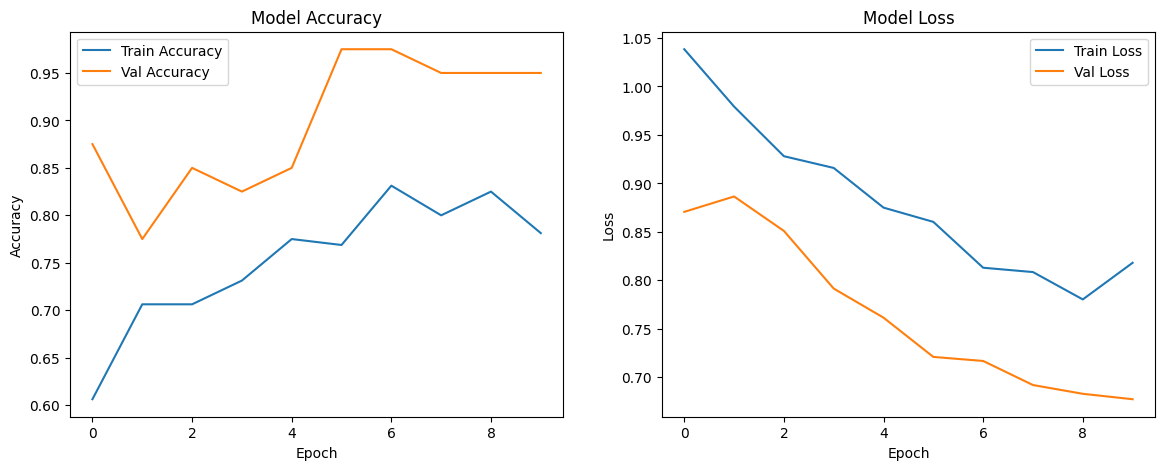

In [23]:
import matplotlib.pyplot as plt


history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10)
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()


plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


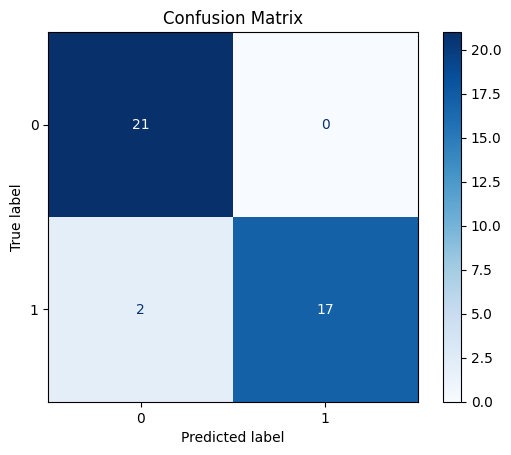

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype(int)


cm = confusion_matrix(y_val, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

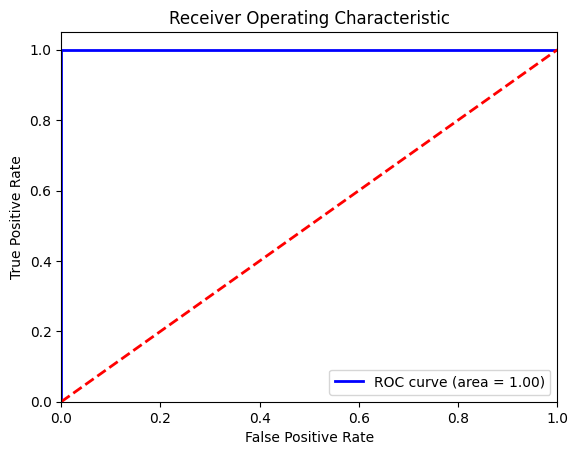

In [25]:
from sklearn.metrics import roc_curve, auc


fpr, tpr, thresholds = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()